# Customer Segmentation - RFM Analysis

## Import Dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')                             
import warnings
warnings.filterwarnings('ignore')                        

## Load the data and process

In [2]:
# Load file
df=pd.read_csv("Sales_.csv")    

In [3]:
df.drop(columns=['Unnamed: 0'],inplace=True)                                     ## Drop the old index column
df.Order_date = df.Order_date.astype('datetime64')                               ## Convert the date column from string to datetime format

In [4]:
df = df[['Customer_ID','Order_ID','Order_date','Quantity','Price']]                  ## Order the columns
df['Revenue'] = df.Quantity * df.Price                                             ## Create a new revenue column

In [5]:
RFM =df.groupby('Customer_ID').agg({'Order_ID':'count','Revenue':'sum','Order_date':lambda x :(df.Order_date.max()-x.max()).days})    ## Group the data by Customer ID and assing different aggregation functions
                                                                                                                                    ## for each column
RFM.rename(columns={'Order_ID':'Frequency','Revenue':'Monetary','Order_date':'Recency'},inplace=True)                            ## Rename the columns

In [6]:
def condition_r(x,col='Frequency'):             ## Create a condition function to convert values in 'F' and 'M' columns
    if x < RFM[col].quantile(0.33):              ## The lower the recency value is the better for the business.
        return 3
    elif x < RFM[col].quantile(0.67):
        return 2
    else:
        return 1

In [7]:
def condition_f_m(x,col='Frequency'):    ## Create a condition function to convert values in 'F' and 'M' columns
    if x < RFM[col].quantile(0.33):       ## The higher the monetary and frequency is the better for the business.
        return 1
    elif x < RFM[col].quantile(0.67):
        return 2
    else:
        return 3

In [8]:
RFM['F_label']=RFM.Frequency.apply(lambda x : condition_f_m(x,col='Frequency'))   ## Apply the conversion functions to the columns
RFM['M_label']=RFM.Monetary.apply(lambda x : condition_f_m(x,col='Monetary'))
RFM['R_label']=RFM.Recency.apply(lambda x : condition_r(x,col='Recency'))

In [9]:
RFM.head(3)

,Frequency,Monetary,Recency,F_label,M_label,R_label
Customer_ID,,,,,,
20000,6,184.5,235,1,1,1
20001,13,951.0,21,3,3,3
20002,7,341.2,63,1,1,2


Newly created labels show the ranking for each row. 4 is the best number. The best row is the one with three '4' values. Such row represents a customer who makes purchase frequently, who has spent high amount of money and who purchased very recently.

In [10]:
RFM['Score'] = RFM[['F_label','M_label','R_label']].sum(axis=1)                      ## Add the values from the three columns
RFM = RFM.sort_values('Score',ascending=False)                           ## Sort  the dataframe by the newly created column

In [11]:
RFM['Segment'] = pd.qcut(RFM.Score,3,['Diamond','Gold','Silver'][::-1])    ## Divide the Score values into 4 different parts
RFM.head()

,Frequency,Monetary,Recency,F_label,M_label,R_label,Score,Segment
Customer_ID,,,,,,,,
20130,13,770.2,9,3,3,3,9,Diamond
20287,11,1075.1,15,3,3,3,9,Diamond
20122,18,931.2,7,3,3,3,9,Diamond
20035,11,720.0,25,3,3,3,9,Diamond
20075,19,1387.3,18,3,3,3,9,Diamond


In [12]:
RFM.Segment.value_counts()                     ## The number of customers belonging to each segment

Silver     119
Diamond     91
Gold        90
Name: Segment, dtype: int64

## RFM Exploratory Data Analysis

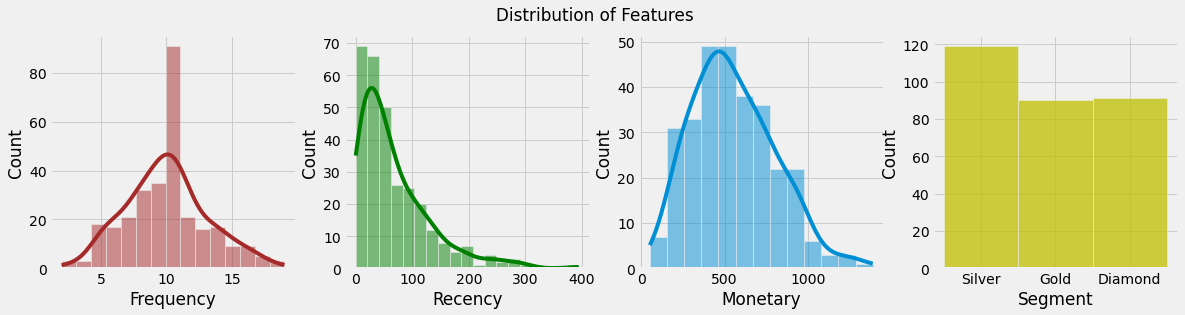

In [13]:
fig,axes = plt.subplots(1,4, figsize=(18,4))                            ## Plotting the distribution of customers by each feature
plt.suptitle('Distribution of Features')                            ## title
sns.histplot(RFM.Frequency,ax = axes[0],color='brown',kde=True)
sns.histplot(RFM.Recency,ax = axes[1],color='green',kde=True)
sns.histplot(RFM.Monetary,ax = axes[2],kde=True)
sns.histplot(RFM.Segment,ax = axes[3],color='y')
plt.show()

## Correlation Between The Features

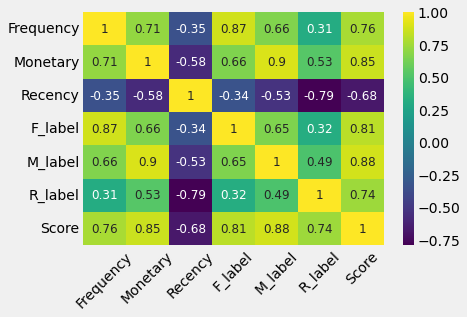

In [14]:
cor = RFM.corr()                                           ## correlation matrix
sns.heatmap(cor,annot=True, cmap= 'viridis',annot_kws={'size':12})
plt.xticks(rotation = 45)
plt.show()

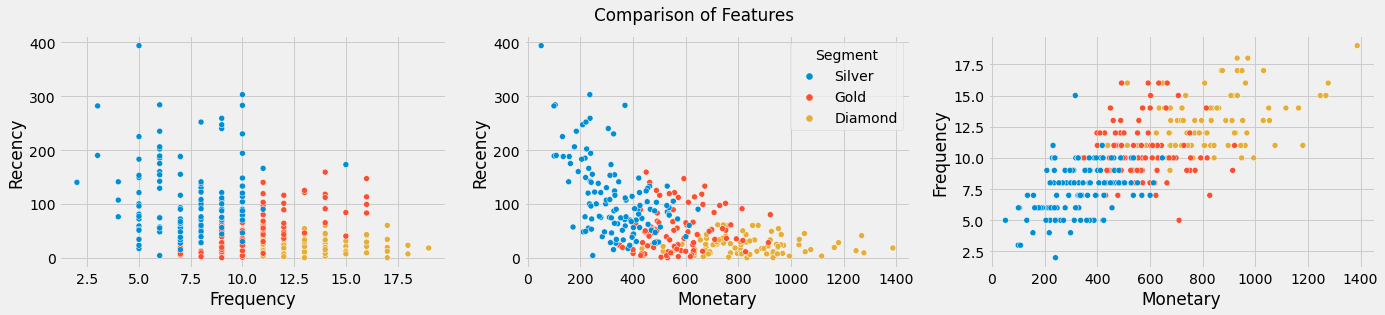

In [15]:
fig,axes = plt.subplots(1,3,figsize=(21,4))                   ## Comparison of customers on different pair of shoes
plt.suptitle('Comparison of Features')
sns.scatterplot(x=RFM.Frequency,y=RFM.Recency,hue=RFM.Segment,ax=axes[0],legend=False)
sns.scatterplot(x=RFM.Monetary,y=RFM.Recency,hue=RFM.Segment,ax=axes[1])
sns.scatterplot(x=RFM.Monetary,y=RFM.Frequency,hue=RFM.Segment,ax=axes[2],legend=False)
plt.show()

Here, these scatterplots show the correlation between the columns;
 **Frequency** is positively correlated with **Monetary**, negatively correlated with **Recency**,
 **Recency** is negatively correlated with **Monetary** and **Frequency**,
 **Monetary** is positively correlated with **Frequency**, negatively correlated with **Recency**.

## Business Strategy According to the Findings

As a result of the analysis, there are 3 main customer segments; Diamond,Gold,Silver. General profile of a customer is as following:

**Diamond** - The most valuable segment is this one. The business's profitability would suffer greatly if these consumers were lost. These customers' actions indicate that they are content with the product's quality, pricing, and other aspects. Therefore, in order to strengthen the relationship even further, customers from this sector should receive promotions that go above and beyond the norm. Giving new productions early access and including them in the business' decision-making processes are two examples.

**Gold** - This group is content with how the firm is run, but there are still a few small things that could be done better. Some could exhibit comparatively low frequency, while others might have modest purchasing volumes. Finding the improvable component and coming up with remedies are essential. For instance, if the frequency is low, it would be a good idea to analyze comparable products on the market because low frequency typically indicates that the buyer occasionally purchases goods from other brands.

**Silver** - Silver customers are the hardest segment to regain. To build the relationship, try fresh price lists, discounts, and accessibility alternatives. As an illustration, if the issue is high recency, it is a fantastic approach to reach out to the clients with new deals and promotions to encourage them to return to their regular habit. The cost of retention is significant for this market. To keep them, additional time, money, and effort are needed. Spending money on this section is not always profitable. Only if increasing profitability is not a top concern and the goal of the company, should this market niche be pursued. To find out why they avoided the merchandise, low cost activities should be chosen.